In [1]:
#Importação de pacotes
import warnings
import pandas as pd
df = pd.read_csv('customer_segmentation.csv')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import joblib # Utilizado para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder #Utilizada para fazer o OneHotEncoding
from sklearn.metrics import mean_squared_error,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from imblearn import under_sampling, over_sampling #Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
from sklearn.metrics import r2_score # Utilizado para medir a acuracia do modelo preditivo

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.options.display.float_format = '{:.2f}'.format

# PRIMEIRAS VISUALIZAÇÕES

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        541909 non-null  int64  
 1   InvoiceNo    541909 non-null  object 
 2   StockCode    541909 non-null  object 
 3   Description  540455 non-null  object 
 4   Quantity     541909 non-null  int64  
 5   InvoiceDate  541909 non-null  object 
 6   UnitPrice    541909 non-null  float64
 7   CustomerID   406829 non-null  float64
 8   Country      541909 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 37.2+ MB


In [3]:
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 9)

# TRADUZINDO BASE DE DADOS

In [5]:
df_traduzida = df.rename(columns={'Description':'DescriçãoProduto','Quantity':'Quantidade','InvoiceDate':'Data','UnitPrice':'Preço','Country':'Pais'})

In [6]:
df_traduzida.head(1)

,index,InvoiceNo,StockCode,DescriçãoProduto,Quantidade,Data,Preço,CustomerID,Pais
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom


# MANIPULAÇÃO E TRATAMENTO DE DADOS

### CRIANDO UMA NOVA COLUNA 

In [7]:
df_traduzida['PreçoTotal'] = df_traduzida['Quantidade'] * df_traduzida['Preço']

In [8]:
df_traduzida.head(1)

,index,InvoiceNo,StockCode,DescriçãoProduto,Quantidade,Data,Preço,CustomerID,Pais,PreçoTotal
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.3


### VERIFICAÇÃO DE VALORES NULOS E DUPLICADOS 

In [9]:
df_traduzida.isnull().sum()

index                    0
InvoiceNo                0
StockCode                0
DescriçãoProduto      1454
Quantidade               0
Data                     0
Preço                    0
CustomerID          135080
Pais                     0
PreçoTotal               0
dtype: int64

In [10]:
df_traduzida.duplicated().sum()

0

In [11]:
df_traduzida = df_traduzida.drop_duplicates()

#### EXCLUINDO VALORES NULOS E COLUNAS

In [12]:
df_traduzida = df_traduzida.dropna()

In [13]:
del df_traduzida['index']
del df_traduzida['CustomerID']

In [14]:
df_traduzida.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   InvoiceNo         406829 non-null  object 
 1   StockCode         406829 non-null  object 
 2   DescriçãoProduto  406829 non-null  object 
 3   Quantidade        406829 non-null  int64  
 4   Data              406829 non-null  object 
 5   Preço             406829 non-null  float64
 6   Pais              406829 non-null  object 
 7   PreçoTotal        406829 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


# ANÁLISE EXPLORATÓRIA

### VERIFCAÇÃO DE OUTLHIERS

Quantidade : int64
Preço : float64
PreçoTotal : float64


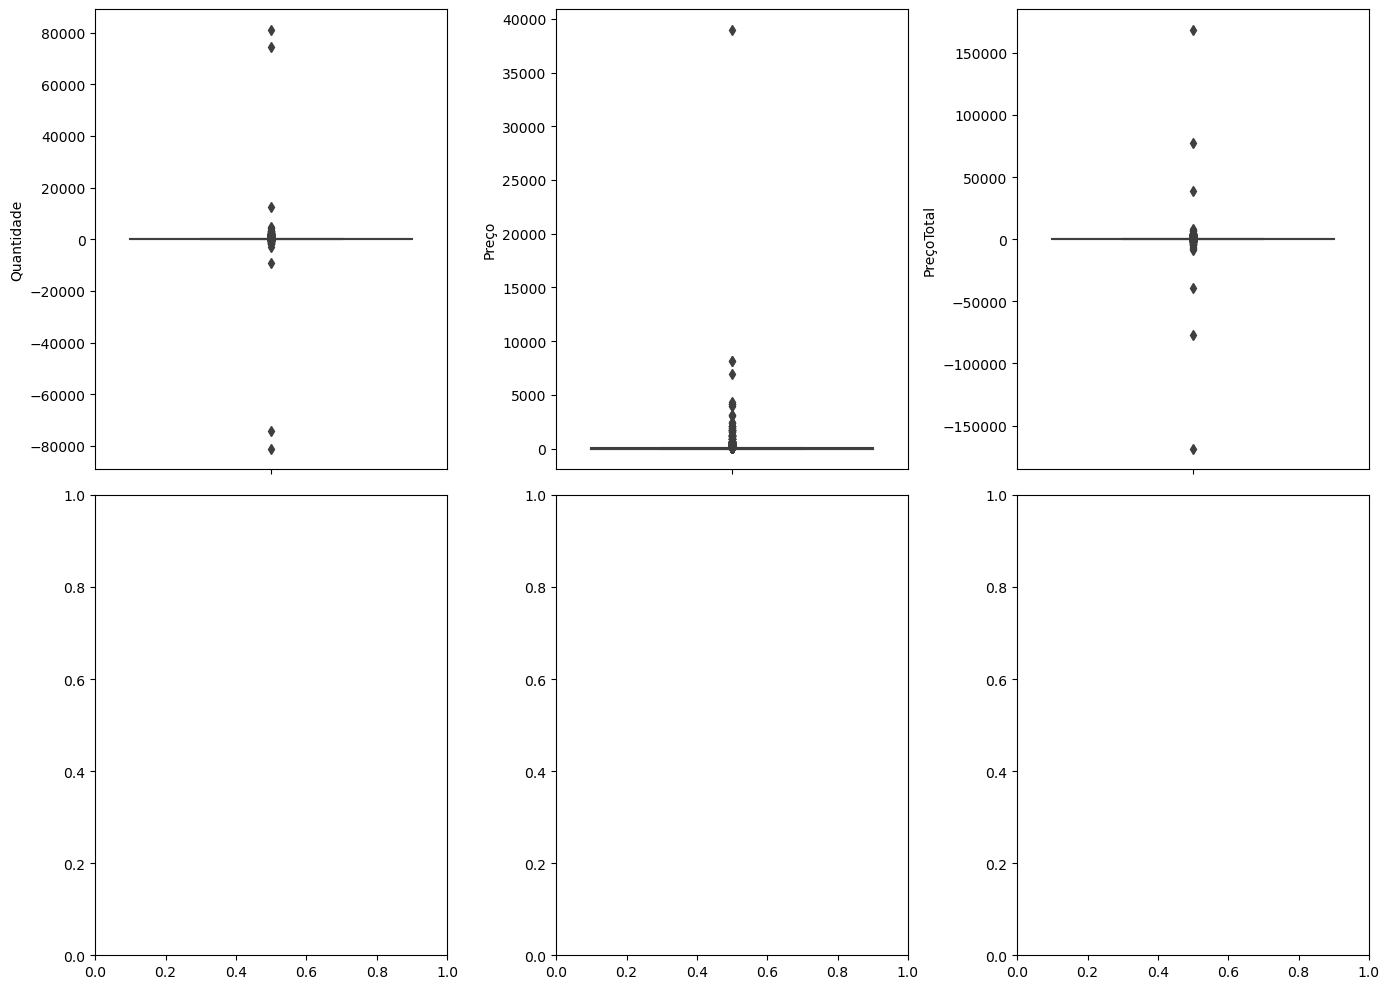

In [15]:
variaveis_numericas = []
for i in df_traduzida.columns[0:16].tolist():
        if df_traduzida.dtypes[i] == 'int64' or df_traduzida.dtypes[i] == 'float64':            
            print(i, ':' , df_traduzida.dtypes[i]) 
            variaveis_numericas.append(i)
 
    
    
    
plt.rcParams["figure.figsize"] = [14.00, 10.00]
plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 10 
plt.rcParams['axes.titlesize'] = 20

f, axes = plt.subplots(2, 3) #8 linhas e 4 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = df_traduzida, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 3:
        linha += 1
        coluna = 0            

plt.show() 

### TRATANDO OS OUTLHIERS

#### PREÇO

In [16]:
df_traduzida['Preço'].max()

38970.0

In [17]:
remocao_comentario_outlhiers= (df_traduzida['Preço']> 0) &  (df_traduzida['Preço']<5000.0)

In [18]:
df_traduzida = df_traduzida[remocao_comentario_outlhiers]

#### QUANTIDADE

In [19]:
df_traduzida['Quantidade'].max()

80995

In [20]:
remocao_comentario_outlhiers= (df_traduzida['Quantidade']> 0) &  (df_traduzida['Quantidade']<74215.0)

In [21]:
df_traduzida = df_traduzida[remocao_comentario_outlhiers]

#### PREÇO TOTAL

In [22]:
df_traduzida['PreçoTotal'].max()

38970.0

In [23]:
remocao_comentario_outlhiers= (df_traduzida['PreçoTotal']> 0) &  (df_traduzida['PreçoTotal']<7144.719999999999)

In [24]:
df_traduzida = df_traduzida[remocao_comentario_outlhiers]

### ESTATÍSTICA

In [25]:
df_traduzida.describe()

,Quantidade,Preço,PreçoTotal
count,397879.000000,397879.000000,397879.000000
mean,12.594605,3.094409,21.643508
std,42.828673,17.909612,71.702970
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,4800.000000,4161.060000,6539.400000


In [26]:
# Moda
from statistics import mode
# https://docs.python.org/3.7/library/statistics.html#module-statistics
mode(df_traduzida['Quantidade'])

1

In [27]:
mode(df_traduzida['Preço'])

1.25

In [28]:
mode(df_traduzida['PreçoTotal'])

15.0

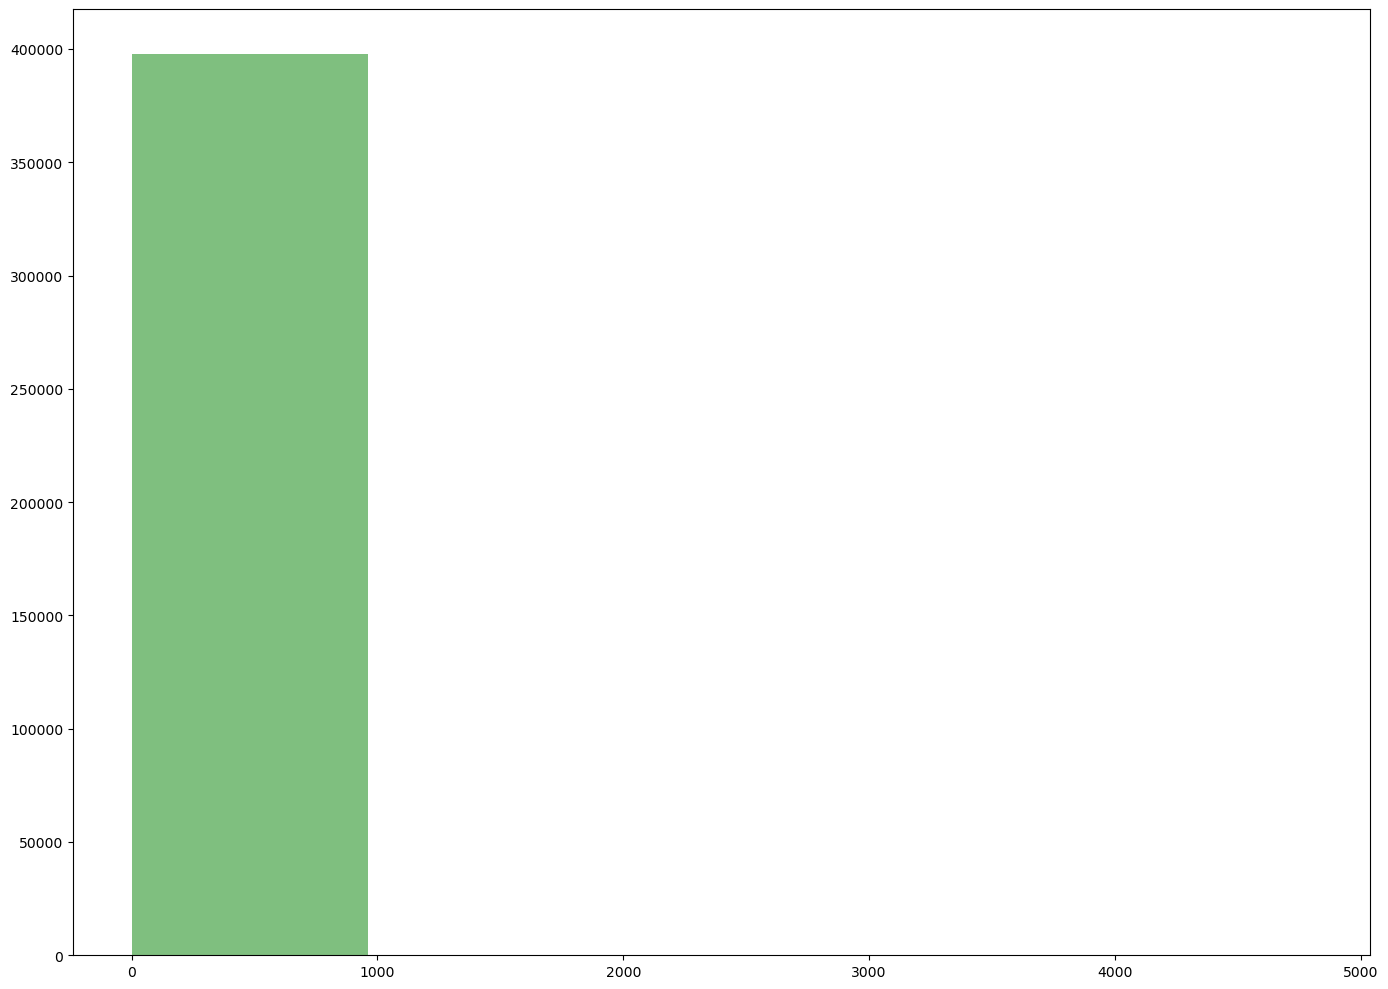

In [29]:

dados = df_traduzida['Quantidade']
num_bins = 5
plt.hist(dados, num_bins, facecolor = 'GREEN', alpha = 0.5)
plt.show()

In [30]:
df_traduzida['Quantidade'].kurt()

1763.5135207782207

In [31]:
df_traduzida['PreçoTotal'].kurt()

1342.442866026841

In [32]:
df_traduzida['Preço'].kurt()

27520.47298261272

array([[<Axes: title={'center': 'Quantidade'}>,
        <Axes: title={'center': 'Preço'}>],
       [<Axes: title={'center': 'PreçoTotal'}>, <Axes: >]], dtype=object)

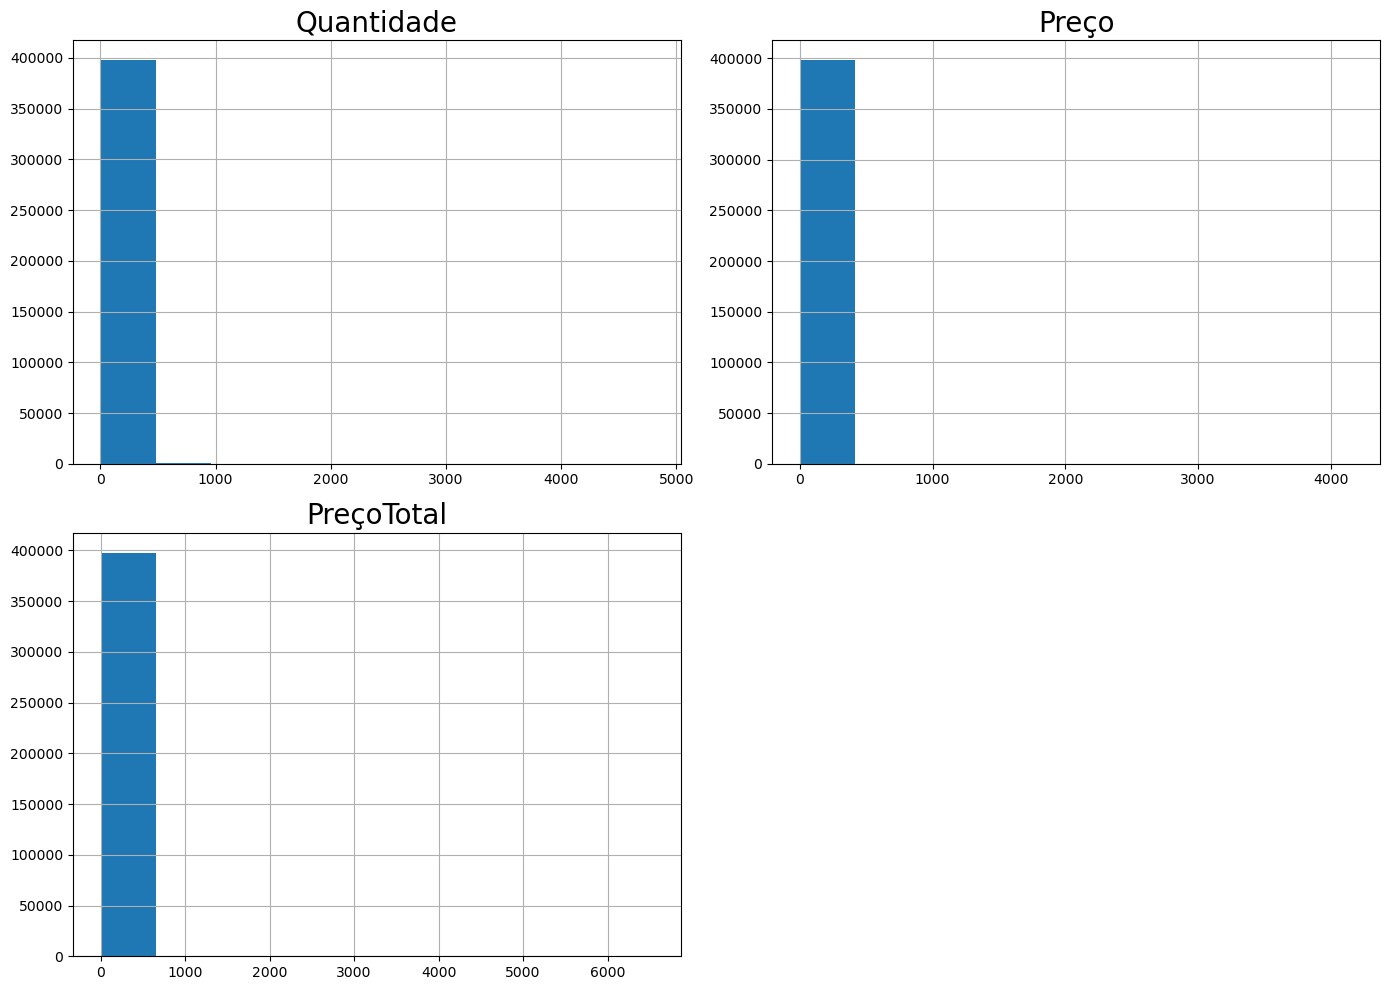

In [33]:
df_traduzida.hist()

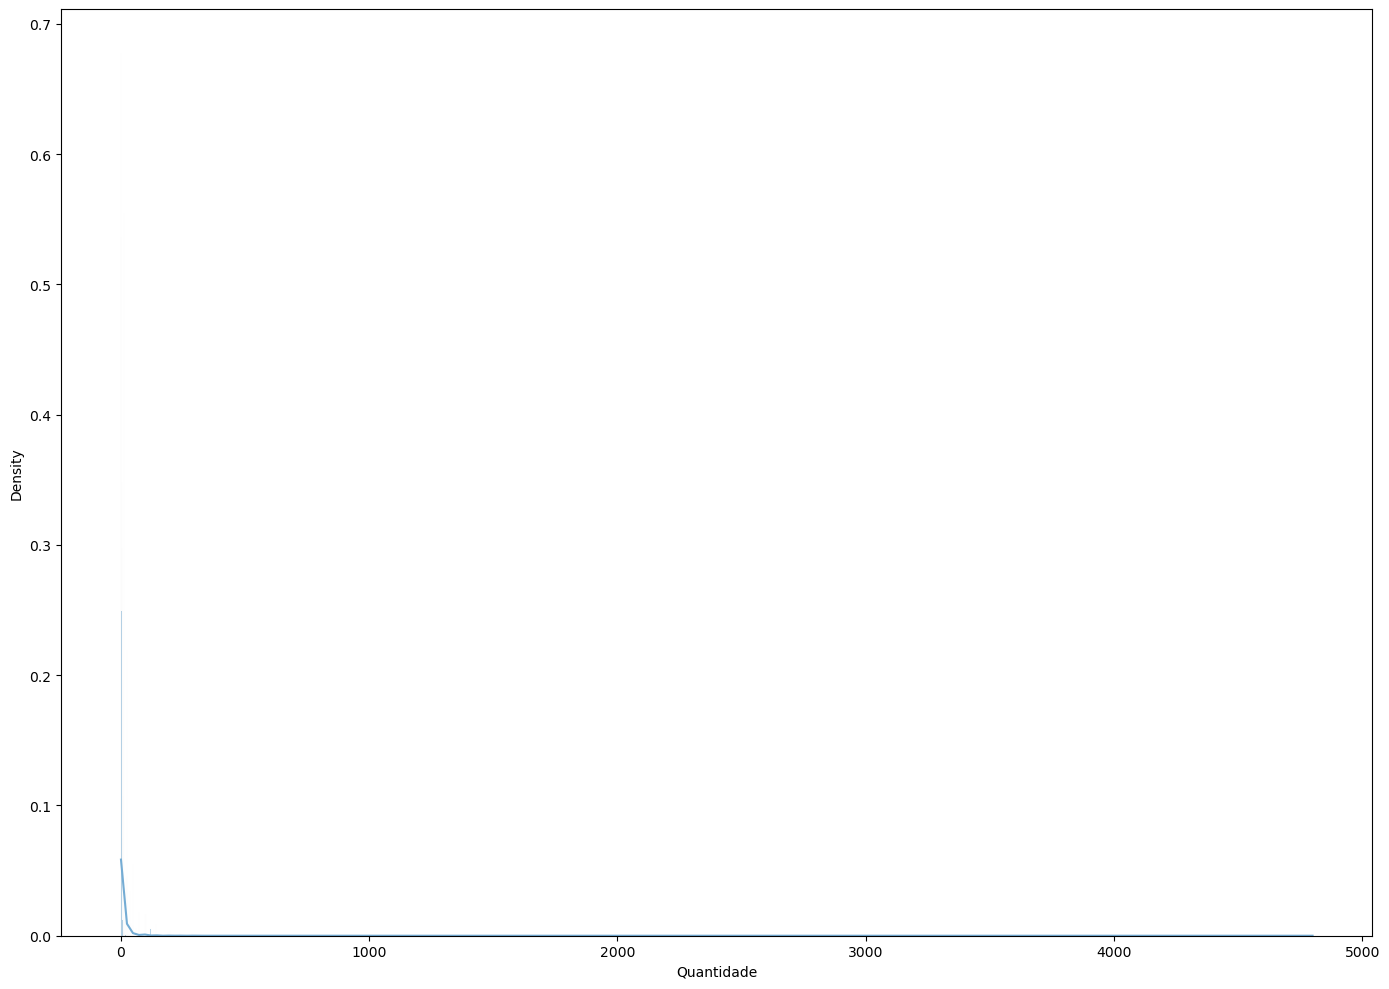

In [34]:
ax = sns.histplot(df_traduzida.Quantidade, stat="density", kde=True, color='#74acd4', lw=1)

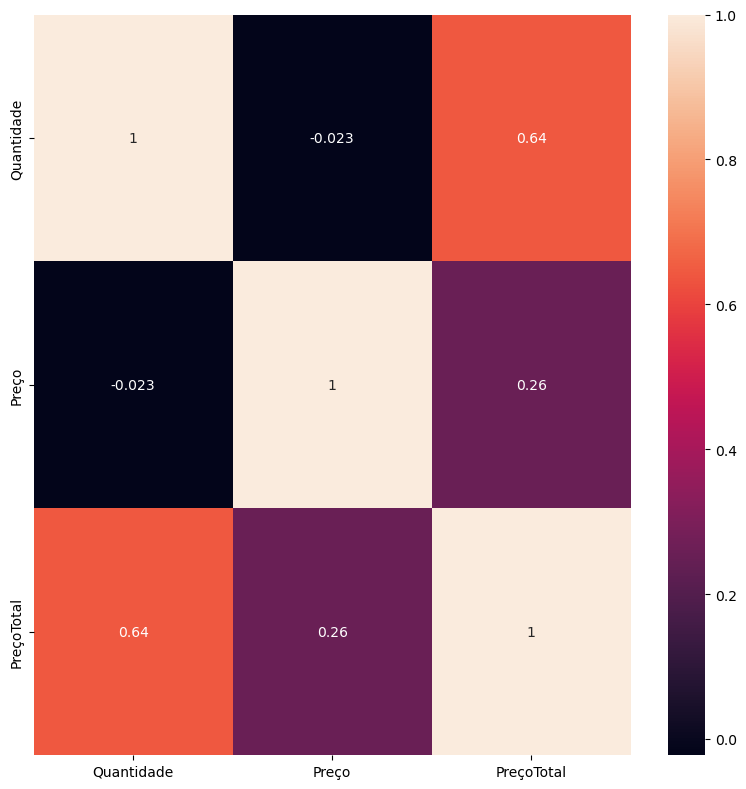

In [35]:
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 10 
plt.rcParams['axes.titlesize'] = 20
plt.rcParams["figure.figsize"] = [8.00, 8.00]
plt.rcParams["figure.autolayout"] = True
sns.heatmap(df_traduzida.corr(), annot=True)
plt.show()

### VALORES UNICOS EM CADA VARIAVEL

In [36]:
valores_unicos = []
for i in df_traduzida.columns[0:12].tolist():
    print(i, ':', len(df_traduzida[i].astype(str).value_counts()))
    valores_unicos.append(len(df_traduzida[i].astype(str).value_counts()))

InvoiceNo : 18528
StockCode : 3664
DescriçãoProduto : 3876
Quantidade : 298
Data : 17279
Preço : 439
Pais : 37
PreçoTotal : 2934


# CLUSTERIZAÇÃO

In [37]:
# Imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [38]:
del df_traduzida['Data']

In [39]:
df_traduzida.head(1)

,InvoiceNo,StockCode,DescriçãoProduto,Quantidade,Preço,Pais,PreçoTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.3


In [40]:
# Cria o encoder
lb = LabelEncoder()

# Aplica o encoder nas variáveis que estão com string
df_traduzida['DescriçãoProduto'] = lb.fit_transform(df_traduzida['DescriçãoProduto'])
df_traduzida['Pais'] = lb.fit_transform(df_traduzida['Pais'])
df_traduzida['StockCode'] = lb.fit_transform(df_traduzida['StockCode'])
# Remove valores missing eventualmente gerados
df_traduzida.dropna(inplace = True)

In [41]:
# Coleta uma amostra de 1% dos dados para não comprometer a memória do computador
df_traduzida, amostra2 = train_test_split(df_traduzida, train_size = .15)

In [42]:
# Aplica redução de dimensionalidade no array das variáveis
pca = PCA(n_components = 2).fit_transform(df_traduzida)

In [43]:
# Determinando um range do Hyperparâmetro  "K"  do Kmeans
k_range = range(1,12)
k_range

range(1, 12)

In [44]:
# Aplicando o modelo K-Means para cada valor de K (esta célula pode levar bastante tempo para ser executada)
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

Text(0, 0.5, '% de Variância Explicada')

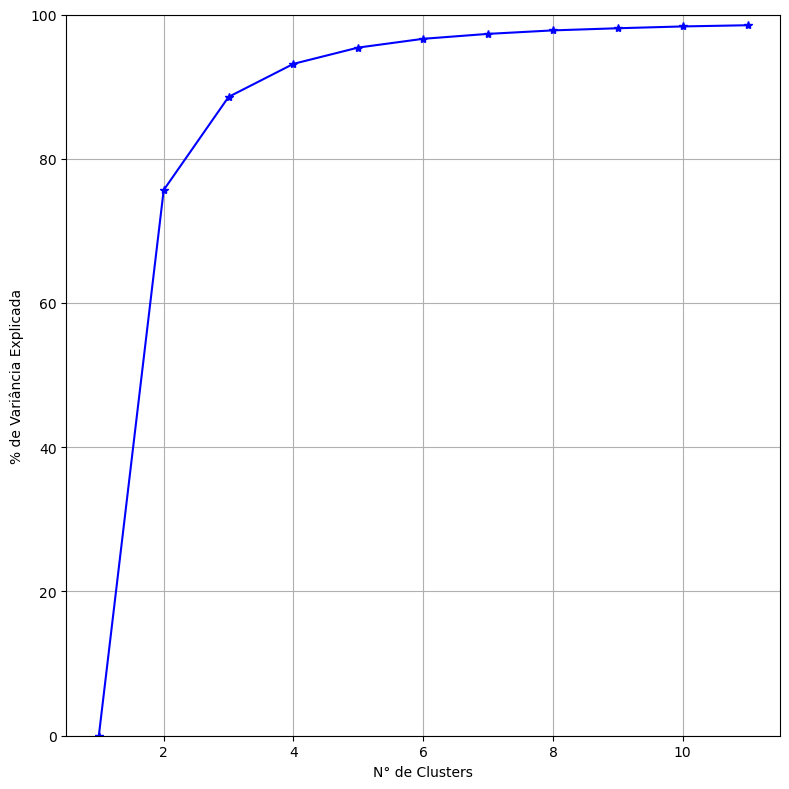

In [45]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('N° de Clusters')
plt.ylabel('% de Variância Explicada')

In [46]:
# Criando um modelo com K = 8
modelo_v1 = KMeans(n_clusters = 8)
modelo_v1.fit(pca)

KMeans()

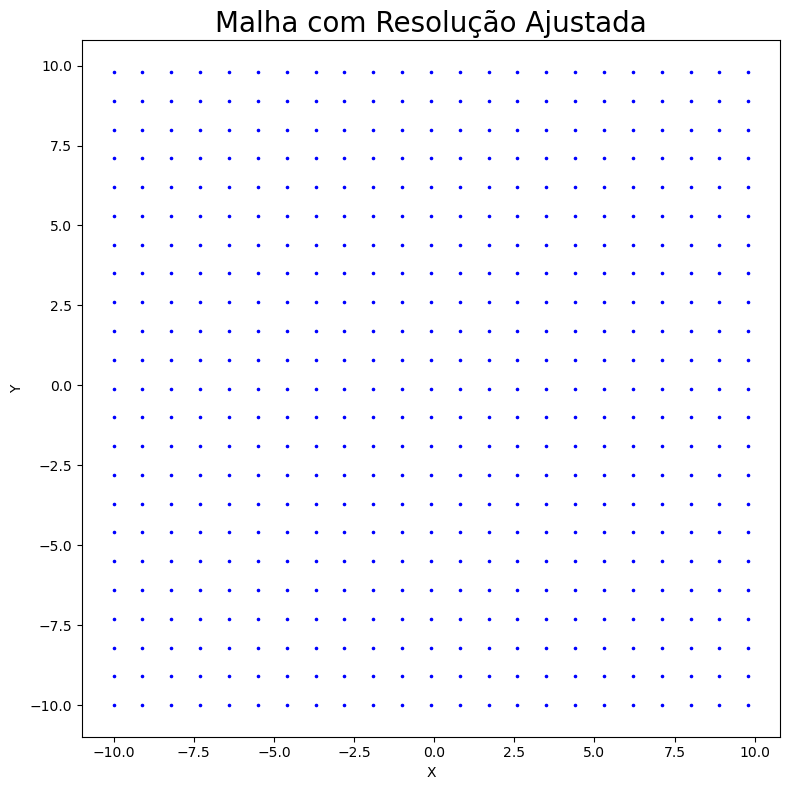

In [47]:
# Defina os limites para x e y
x_min, x_max = -10, 10
y_min, y_max = -10, 10

# Reduza a resolução da malha (aumente o valor de step)
step = 0.9  # Ajuste este valor conforme necessário

# Crie a malha com a resolução ajustada
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

# Faça algo com a matriz gerada (por exemplo, plotar)
plt.scatter(xx, yy, s=10, c='b', marker='.')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Malha com Resolução Ajustada')
plt.show()
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

In [48]:
#Métrica de avaliação para Clusterização
# The best value is 1 and the worst value is -1
#?silhouette_score

In [49]:
# Criando um modelo com K = 2
modelo_v2 = KMeans(n_clusters = 2)
modelo_v2.fit(pca)

KMeans(n_clusters=2)

In [50]:
# Silhouette Score
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6298695386096812

In [51]:
#df_traduzida.head(1)

In [52]:
nomes = ['InvoiceNo','StockCode','DescriçãoProduto','Quantidade','Preço','Pais','PreçoTotal']

In [53]:
# Incluindo o n° do cluster na base de clientes
cluster_map = pd.DataFrame(df_traduzida, columns = nomes)
cluster_map['Preço'] = pd.to_numeric(cluster_map['Preço'])
cluster_map['cluster'] = modelo_v2.labels_

In [54]:
cluster_map.shape

(59681, 8)